In [1]:
!kaggle datasets download -d fedesoriano/traffic-prediction-dataset
! unzip traffic-prediction-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset
License(s): copyright-authors
100% 277k/277k [00:00<00:00, 444kB/s]
100% 277k/277k [00:00<00:00, 444kB/s]
Archive:  traffic-prediction-dataset.zip
  inflating: traffic.csv             


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [3]:
df = pd.read_csv('/content/traffic.csv', parse_dates=['DateTime'], index_col='DateTime')

In [4]:
df = df.drop(columns=['ID'])  # Drop unnecessary ID column
df.sort_index(inplace=True)  # Sort by DateTime

In [5]:
# 2. Handle Duplicates and Resample Data
df = df.groupby(df.index).mean()  # Group by DateTime to handle duplicates
df_daily = df.resample('D').sum()  # Resample daily


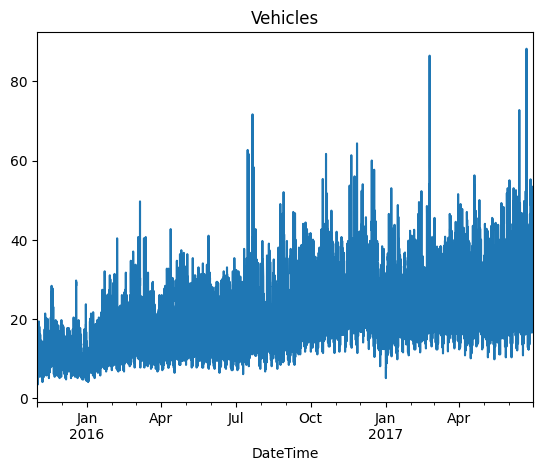

In [6]:
df['Vehicles'].plot(title='Vehicles')
plt.show()

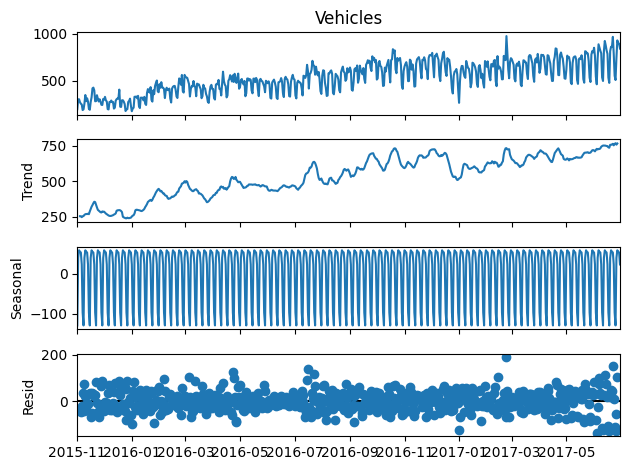

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_daily['Vehicles'], model='additive', period=7)  # Weekly seasonality
decomposition.plot()
plt.show()

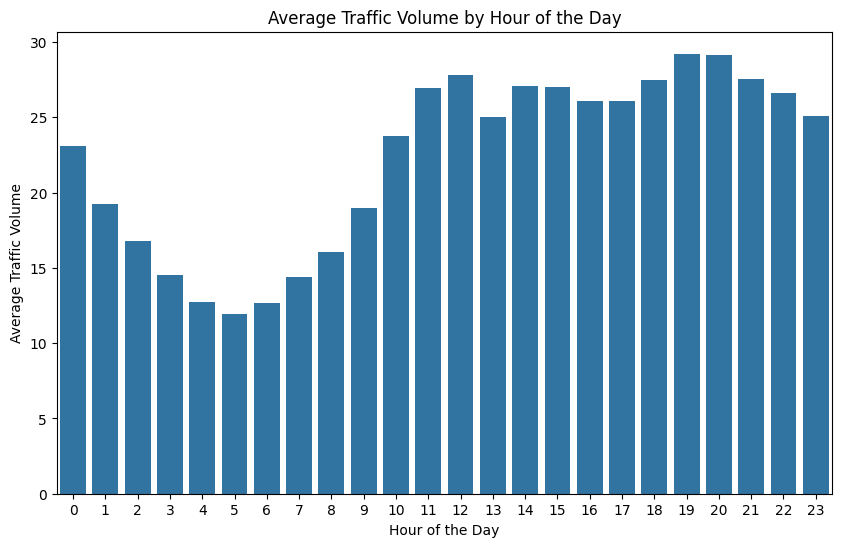

In [8]:
hourly_avg = df.groupby(df.index.hour)['Vehicles'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=hourly_avg.index, y=hourly_avg.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Average Traffic Volume')
plt.title('Average Traffic Volume by Hour of the Day')
plt.show()

In [9]:
Q1 = df['Vehicles'].quantile(0.25)
Q3 = df['Vehicles'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Vehicles'] >= lower_bound) & (df['Vehicles'] <= upper_bound)]


In [10]:
df['prev_traffic_volume'] = df['Vehicles'].shift(1)
df.dropna(inplace=True)

<ipython-input-10-cf271aa0964e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prev_traffic_volume'] = df['Vehicles'].shift(1)
<ipython-input-10-cf271aa0964e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [11]:
train_start = '2015-11-01 01:00:00'
val_start = '2017-01-01 00:00:00'
test_start = '2017-04-01 00:00:00'
end_date = '2017-06-30 23:00:00'

train = df[train_start:val_start]
val = df[val_start:test_start]
test = df[test_start:end_date]

In [12]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)

train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns)
val_scaled_df = pd.DataFrame(val_scaled, columns=val.columns)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns)




In [13]:
win = 24  # Using 24 hours as look_back window

xy_train = tf.keras.utils.timeseries_dataset_from_array(
    data=train_scaled_df[['prev_traffic_volume']].values,
    targets=train_scaled_df.iloc[win:, 1].values,
    sequence_length=win,
    batch_size=32
)

xy_val = tf.keras.utils.timeseries_dataset_from_array(
    data=val_scaled_df[['prev_traffic_volume']].values,
    targets=val_scaled_df.iloc[win:, 1].values,
    sequence_length=win,
    batch_size=32
)

xy_test = tf.keras.utils.timeseries_dataset_from_array(
    data=test_scaled_df[['prev_traffic_volume']].values,
    targets=test_scaled_df.iloc[win:, 1].values,
    sequence_length=win,
    batch_size=32
)


In [14]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(win, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
history = model.fit(xy_train, validation_data=xy_val, epochs=20, batch_size=32)




Epoch 1/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0111 - val_loss: 0.0125
Epoch 2/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0057 - val_loss: 0.0097
Epoch 3/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0048 - val_loss: 0.0081
Epoch 4/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0043 - val_loss: 0.0074
Epoch 5/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0040 - val_loss: 0.0066
Epoch 6/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0038 - val_loss: 0.0060
Epoch 7/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0036 - val_loss: 0.0055
Epoch 8/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0035 - val_loss: 0.0057
Epoch 9/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0035 - val_loss: 0.0058
Epoch 10/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0034 - val_loss: 0.0060
Epoch 11/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0034 - val_loss: 0.0063
Epoch 12/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 1

In [16]:
# 13. Evaluate the Model
loss = model.evaluate(xy_test)
print(f'Test Loss: {loss}')

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078
Test Loss: 0.007821756415069103


In [17]:
loss = model.evaluate(xy_test)
print(f'Test Loss: {loss}')

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078
Test Loss: 0.007821756415069103


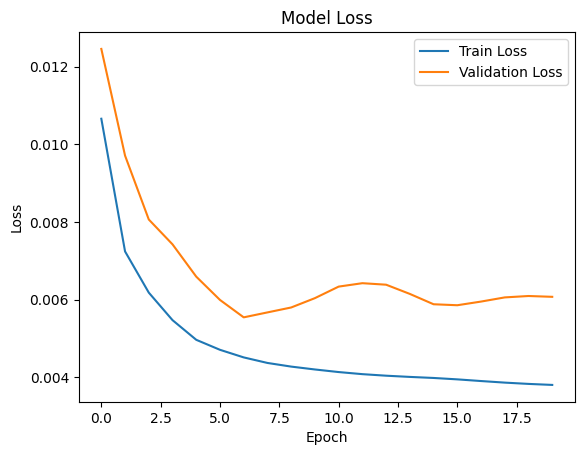

In [19]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [29]:
recpredictions = np.zeros((len(predictions), train_scaled_df.shape[1]))

recpredictions[:, 1] = predictions[:, 0]

original_scale_predictions = scaler.inverse_transform(recpredictions)

predicted= original_scale_predictions[:, 1]


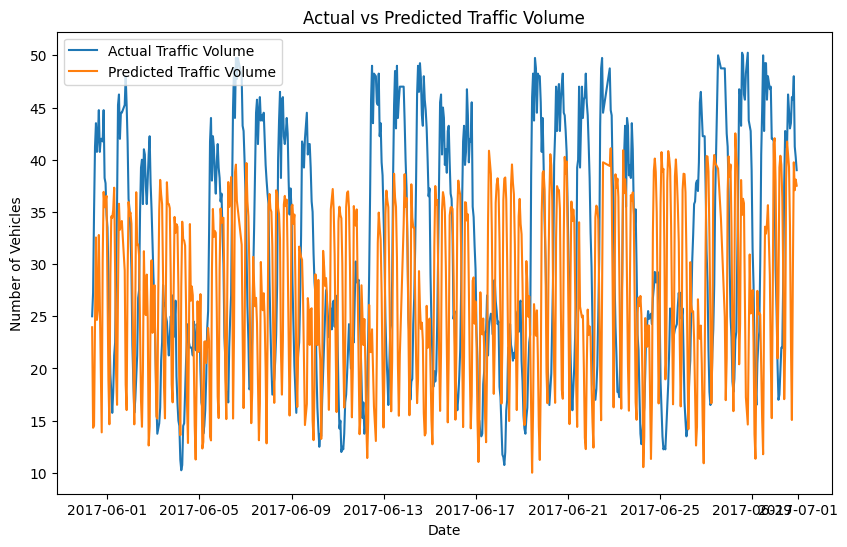

In [30]:
# 16. Plot Actual vs Predicted Traffic Volume
plt.figure(figsize=(10, 6))
plt.plot(test.index[-len(predicted_traffic_volume):], test['Vehicles'][-len(predicted_traffic_volume):], label='Actual Traffic Volume')
plt.plot(test.index[-len(predicted_traffic_volume):], predicted_traffic_volume, label='Predicted Traffic Volume')
plt.title('Actual vs Predicted Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()